<a href="https://colab.research.google.com/github/String-ru/AIFFEL_quest_cr/blob/main/DeepCV/0222_7pm_Temp_Save_MainQuest03_Lung_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle API 설치

pip install kaggle 명령어를 사용하여 Kaggle API를 설치 (Kaggle을 Colab에서 활용할 수 있게 됨)

In [1]:
pip install kaggle #Kaggle API 클라이언트를 설치(Kaggle 활용 가능해짐)

# Google Drive 마운트

drive.mount('/content/drive') 사용하여 Google Drive를 Colab 환경에 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive') #Google Colab 환경에서 Google Drive를 마운트(연결)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# data set 다운로드

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia 사용하여

Kaggle API를 통해 "chest-xray-pneumonia" data set 다운로드

(출력 결과: 데이터셋의 URL, 라이선스 및 다운로드 진행 상황 등의 정보)

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
#Kaggle API를 사용하여 "chest-xray-pneumonia" 데이터셋을 다운로드

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
import os

# zip 파일 경로 설정 (변경된 폴더 이름과 Google Drive 첫 화면 경로 반영)
zip_file_path = '/content/drive/MyDrive/lung_cancer.zip'
extract_folder_path = '/content/drive/MyDrive/lung_cancer'

# zip 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

# 추출된 폴더 리스트 확인
extracted_folders = os.listdir(extract_folder_path)
print(extracted_folders)

['chest_xray']


In [5]:
!mkdir -p ~/.kaggle #~/.kaggle이라는 디렉토리 만들기
!mv /content/drive/MyDrive/kaggle.json ~/.kaggle/
#Kaggle API token 파일인 kaggle.json을 Kaggle API와 통신할 수 있도록 적절한 디렉터리로 이동

mv: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [9]:
ROOT_PATH = "/content/drive/MyDrive/lung_cancer"
TEST_PATH = os.path.join(ROOT_PATH, "chest_xray/test")

In [11]:
import glob

TEST_PATH = os.path.join(ROOT_PATH, "chest_xray/test/*/*")  # 두 단계 내려가야 함

# 모든 테스트 이미지 파일 경로 가져오기
test_filenames = glob.glob(TEST_PATH)

print(f"✅ 총 {len(test_filenames)}개의 테스트 이미지가 있습니다!")
print(test_filenames[:5])  # 일부만 출력해보기

✅ 총 624개의 테스트 이미지가 있습니다!
['/content/drive/MyDrive/lung_cancer/chest_xray/test/NORMAL/IM-0001-0001.jpeg', '/content/drive/MyDrive/lung_cancer/chest_xray/test/NORMAL/IM-0003-0001.jpeg', '/content/drive/MyDrive/lung_cancer/chest_xray/test/NORMAL/IM-0005-0001.jpeg', '/content/drive/MyDrive/lung_cancer/chest_xray/test/NORMAL/IM-0006-0001.jpeg', '/content/drive/MyDrive/lung_cancer/chest_xray/test/NORMAL/IM-0007-0001.jpeg']


In [12]:
# 필요한 패키지들 임포트
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/content/drive/MyDrive/lung_cancer'  # Google Drive 내 데이터 경로
TRAIN_PATH = os.path.join(ROOT_PATH, 'chest_xray/train/*/*')  # 훈련용 이미지 경로
VAL_PATH = os.path.join(ROOT_PATH, 'chest_xray/val/*/*')  # 검증용 이미지 경로
TEST_PATH = os.path.join(ROOT_PATH, 'chest_xray/test/*/*')  # 테스트용 이미지 경로

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print("ROOT_PATH:", ROOT_PATH)

ROOT_PATH: /content/drive/MyDrive/lung_cancer


In [13]:
# 데이터셋 파일 경로 로드
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 데이터셋 파일 개수 출력
print(f"Train filenames count: {len(train_filenames)}")
print(f"Test filenames count: {len(test_filenames)}")
print(f"Val filenames count: {len(val_filenames)}")

Train filenames count: 5216
Test filenames count: 624
Val filenames count: 16


In [14]:
# 훈련 데이터와 검증 데이터를 filenames에 합친 후, 8:2로 나누기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 훈련 데이터 80%, 검증 데이터 20%로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 나눠진 데이터셋 크기 출력
print(f"Train filenames count after split: {len(train_filenames)}")
print(f"Val filenames count after split: {len(val_filenames)}")

Train filenames count after split: 4185
Val filenames count after split: 1047


In [15]:
# 파일 경로의 끝에서 두 번째 부분을 확인하여 양성과 음성을 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

    # 이미지를 알맞은 형식으로 바꿔주는 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)  # float32 타입으로 변환
    img = tf.image.resize(img, IMAGE_SIZE)  # 이미지 크기 조정
    img = img * 255.0  # 정규화된 값을 0~255로 변환
    img = tf.cast(img, tf.uint8)  # 최종적으로 uint8로 캐스팅
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어오는 함수
def process_path(file_path):
    label = tf.cond(
        tf.strings.regex_full_match(file_path, '.*PNEUMONIA.*'),  # 'PNEUMONIA'가 포함되어 있으면
        lambda: 1,  # PNEUMONIA -> 1
        lambda: 0   # NORMAL -> 0
    )

    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, label

In [16]:
# tf.data.Dataset으로 변환
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

# 데이터셋의 크기 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

print(f"Training images count: {TRAIN_IMG_COUNT}")
print(f"Validating images count: {VAL_IMG_COUNT}")
print(f"Test images count: {TEST_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047
Test images count: 624


In [17]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  # 셔플
    ds = ds.repeat()  # 데이터를 반복
    ds = ds.batch(BATCH_SIZE)  # 배치 처리
    ds = ds.prefetch(buffer_size=AUTOTUNE)  # 데이터 미리 로드
    return ds

train_ds = prepare_for_training(train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE))
val_ds = prepare_for_training(val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE))
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

for image, label in train_ds.take(1):  # train_ds에서 첫 번째 배치를 가져옴
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (16, 180, 180, 3)
Label:  [1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1]


# data 시각화

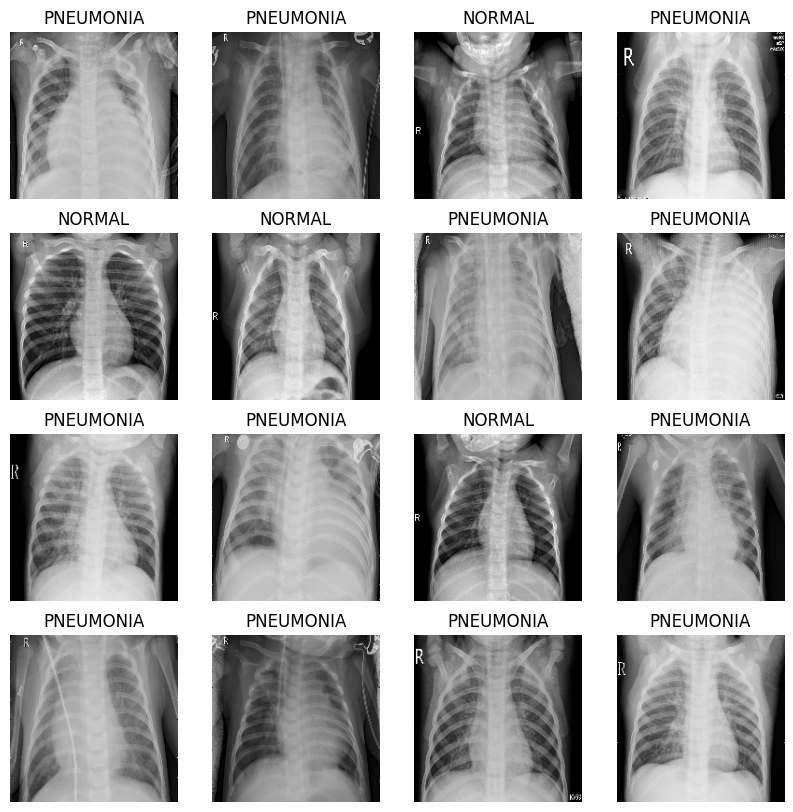

In [20]:
# 이미지 배치를 입력하면 여러 장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n] / 255.0)  # 이미지 값을 0~1 범위로 정규화
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

# 이미지 배치와 라벨 배치를 가져와서 시각화
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN 모델링

In [21]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [22]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [23]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

# 데이터 imbalance 처리

In [24]:
# 'NORMAL'과 'PNEUMONIA' 클래스의 이미지 개수 계산
COUNT_NORMAL = len([f for f in train_filenames if 'NORMAL' in f])
COUNT_PNEUMONIA = len([f for f in train_filenames if 'PNEUMONIA' in f])

# weight 계산
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

# class_weight 딕셔너리
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [25]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.7646 - loss: 0.4795 - precision: 0.9280 - recall: 0.7323 - val_accuracy: 0.7375 - val_loss: 0.8398 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/10
110/261 ━━━━━━━━━━━━━━━━━━━━ 3:05 1s/step - accuracy: 0.9014 - loss: 0.2852 - precision: 0.9688 - recall: 0.8958

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)

#결과

~~~

의료 데이터의 경우 구하기도 어렵고 구하더라도 데이터가 작은 경우가 많이 있습니다. 이런 문제를 해결하기 위해 Data augmentation 방법을 많이 시도합니다.
Data augmentation 은 각 데이터에 최적화된 방법을 찾기가 어렵고 제약사항이 많습니다. 그래서 의료분야에서는 기본적인 Data augmentation 방법들을 많이 사용합니다. 이미지 회전, 가우시안 노이즈 추가 방법 등을 많이 사용합니다. 특히 장기의 크기는 사람마다 거의 바뀌지 않습니다. 이런 특성을 이용한 방법이 노이즈 추가 방법입니다.

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [224, 224]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 30
EPOCHS = 15

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)  # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)  # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path)  # 라벨 검출
    img = tf.io.read_file(file_path)  # 이미지 읽기
    img = decode_img(img)  # 이미지를 알맞은 형식으로 수정

    # sample_weight 추가
    sample_weight = tf.cast(label, tf.float32) * tf.cast((weight_for_1 if label else weight_for_0), tf.float32)

    return img, label, sample_weight

train_ds = train_ds.repeat()
train_ds = train_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

def preprocess_image(image):
    image = tf.image.resize(image, IMAGE_SIZE)  # 224x224로 리사이즈
    return image

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

# 모델 훈련
# 훈련 시 steps_per_epoch 설정
history = model.fit(train_ds, epochs=15, validation_data=val_ds, steps_per_epoch=len(train_ds) // BATCH_SIZE)

# 훈련 과정 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    if 'val_' + met in history.history:
        ax[i].plot(history.history['val_' + met])  # 검증 메트릭 존재시 plot
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# test_ds 정의
test_filenames = tf.io.gfile.glob(TEST_PATH)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

# 테스트 데이터셋에 대해 이미지 로딩 및 처리
test_ds = test_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')

In [ ]:
# 데이터 증강 함수 정의
def augment(image, label, sample_weight):
    # 좌우 반전
    image = tf.image.random_flip_left_right(image)

    # 랜덤 회전 (0, 90, 180, 270도 회전)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=(), minval=0, maxval=4, dtype=tf.int32))

    # 밝기 조정
    image = tf.image.random_brightness(image, max_delta=0.1)

    # 대비 조정
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # 크기 조정 (이미지 크기를 [224, 224]로 고정)
    image = tf.image.resize(image, [224, 224])

    # 색상 변화
    image = tf.image.random_hue(image, max_delta=0.1)

    return image, label, sample_weight

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # 증강을 적용한 배치 처리
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

# 데이터셋 준비 (증강 적용)
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 모델 훈련
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

# 모델 훈련 과정 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    if 'val_' + met in history.history:
        ax[i].plot(history.history['val_' + met])  # 검증 메트릭 존재시 plot
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 테스트 데이터셋 정의 및 평가
test_filenames = tf.io.gfile.glob(TEST_PATH)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
test_ds = test_list_ds.map(process_path).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')